## 08. N-Body Neural Force Fields

In [1]:
# disable GPU. Remove this if you've compiled HOOMD for GPU
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'


# import the hoomd, htf packages
import hoomd
import hoomd.htf as htf
import tensorflow as tf
import matplotlib.pyplot as plt
from MDAnalysis import Universe

## Build the SimModel

Here we build a 2 hidden-layer N-body neural force fields. The inputs are the nearest N neighbors.

In [2]:
class NlistNN(htf.SimModel):
    def setup(self, dim, top_neighs):
        self.dense1 = tf.keras.layers.Dense(dim)
        self.dense2 = tf.keras.layers.Dense(dim)
        self.last = tf.keras.layers.Dense(1)
        self.top_neighs = top_neighs

    def compute(self, nlist, positions, box):
        rinv = htf.nlist_rinv(nlist)
        # closest neighbors have largest value in 1/r, take top
        sorted_n = tf.reshape(tf.sort(rinv, axis=1, direction='DESCENDING'), [-1, self.nneighbor_cutoff])
        top_n = sorted_n[:, :self.top_neighs]
        # run through NN
        x = self.dense1(top_n)
        x = self.dense2(x)
        pair_energy = self.last(x)
        # get per-particle energy
        energy = tf.reduce_sum(pair_energy, axis=1)
        forces = htf.compute_nlist_forces(nlist, energy)
        # don't output last column of forces, pairwise energy, since it's meaningless here
        return forces[:,:3], energy


## Training from a Trajectory File

We will compile our model and then train against a trajectory. If this were a real example, we would be training against the forces in the trajectory but this trajectory (to save space) has no forces. Instead, we will train to make our forces match the positions of the trajctory, which makes no physical sense, but it has the correct dimensions.

In [3]:
model = NlistNN(128, dim=16, top_neighs=8)
# when we compile, add a None loss so as to not train the second output
# which is energy
model.compile('Adam', ['MeanSquaredError', None])
universe = Universe('test_topol.pdb', 'test_traj.trr')
losses = []
for epoch in range(3):
    for inputs, ts in htf.iter_from_trajectory(128, universe, r_cut=25, period=5):
        #labels = ts.forces
        labels = ts.positions
        loss = model.train_on_batch(inputs, labels)
        losses.append(loss)

100%|██████████| 801/801 [00:01<00:00, 537.72it/s]


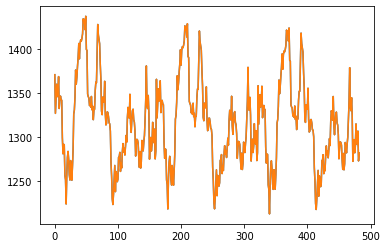

In [4]:
plt.plot(losses)
plt.show()

## Inferrence with the Model

Now we will run a particle simulation with our model.

In [5]:
########### Hoomd-Sim Code ################
hoomd.context.initialize('--mode=cpu')

tfcompute = htf.tfcompute(model)

# create a square lattice
system = hoomd.init.create_lattice(unitcell=hoomd.lattice.sq(a=1.2),
                                    n=[16,16])
nlist = hoomd.md.nlist.cell()
# NVT ensemble
hoomd.md.integrate.mode_standard(dt=1e-4)
hoomd.md.integrate.nvt(group=hoomd.group.all(), kT=0.1, tau=0.5).randomize_velocities(seed=1)
tfcompute.attach(nlist, r_cut=5, save_output_period=5)
#run with our silly model
hoomd.run(1e3)

HOOMD-blue v2.9.0 CUDA (10.1) DOUBLE HPMC_MIXED SSE SSE2 SSE3 SSE4_1 SSE4_2 AVX AVX2 
Compiled: 03/03/2021
Copyright (c) 2009-2019 The Regents of the University of Michigan.
-----
You are using HOOMD-blue. Please cite the following:
* J A Anderson, C D Lorenz, and A Travesset. "General purpose molecular dynamics
  simulations fully implemented on graphics processing units", Journal of
  Computational Physics 227 (2008) 5342--5359
* J Glaser, T D Nguyen, J A Anderson, P Lui, F Spiga, J A Millan, D C Morse, and
  S C Glotzer. "Strong scaling of general-purpose molecular dynamics simulations
  on GPUs", Computer Physics Communications 192 (2015) 97--107
-----
no CUDA-capable device is detected
HOOMD-blue is running on the CPU
notice(2): Group "all" created containing 256 particles
notice(2): Force mode is FORCE_MODE.tf2hoomd 
notice(2): Starting TensorflowCompute 
notice(2): completed reallocate
notice(2): Setting flag indicating virial modification will occur
notice(2): -- Neighborlist e

## Analysis

This model is not properly trained so there is not much analysis to do. We'll just take a look at the energy

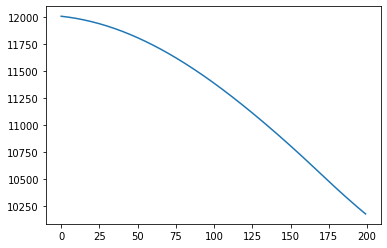

In [6]:
e = tf.reduce_sum(tfcompute.outputs[0], axis=1)
plt.plot(e)
plt.show()